# Skip-gram word2vec

In this notebook, I'll lead you through using TensorFlow to implement the word2vec algorithm using the skip-gram architecture. By implementing this, you'll learn about embedding words for use in natural language processing. This will come in handy when dealing with things like machine translation.

## Readings

Here are the resources I used to build this notebook. I suggest reading these either beforehand or while you're working on this material.

* A really good [conceptual overview](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/) of word2vec from Chris McCormick 
* [First word2vec paper](https://arxiv.org/pdf/1301.3781.pdf) from Mikolov et al.
* [NIPS paper](http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf) with improvements for word2vec also from Mikolov et al.
* An [implementation of word2vec](http://www.thushv.com/natural_language_processing/word2vec-part-1-nlp-with-deep-learning-with-tensorflow-skip-gram/) from Thushan Ganegedara
* TensorFlow [word2vec tutorial](https://www.tensorflow.org/tutorials/word2vec)

## Word embeddings

When you're dealing with words in text, you end up with tens of thousands of classes to predict, one for each word. Trying to one-hot encode these words is massively inefficient, you'll have one element set to 1 and the other 50,000 set to 0. The matrix multiplication going into the first hidden layer will have almost all of the resulting values be zero. This a huge waste of computation. 

![one-hot encodings](assets/one_hot_encoding.png)

To solve this problem and greatly increase the efficiency of our networks, we use what are called embeddings. Embeddings are just a fully connected layer like you've seen before. We call this layer the embedding layer and the weights are embedding weights. We skip the multiplication into the embedding layer by instead directly grabbing the hidden layer values from the weight matrix. We can do this because the multiplication of a one-hot encoded vector with a matrix returns the row of the matrix corresponding the index of the "on" input unit.

![lookup](assets/lookup_matrix.png)

Instead of doing the matrix multiplication, we use the weight matrix as a lookup table. We encode the words as integers, for example "heart" is encoded as 958, "mind" as 18094. Then to get hidden layer values for "heart", you just take the 958th row of the embedding matrix. This process is called an **embedding lookup** and the number of hidden units is the **embedding dimension**.

<img src='assets/tokenize_lookup.png' width=500>
 
There is nothing magical going on here. The embedding lookup table is just a weight matrix. The embedding layer is just a hidden layer. The lookup is just a shortcut for the matrix multiplication. The lookup table is trained just like any weight matrix as well.

Embeddings aren't only used for words of course. You can use them for any model where you have a massive number of classes. A particular type of model called **Word2Vec** uses the embedding layer to find vector representations of words that contain semantic meaning.



## Word2Vec

The word2vec algorithm finds much more efficient representations by finding vectors that represent the words. These vectors also contain semantic information about the words. Words that show up in similar contexts, such as "black", "white", and "red" will have vectors near each other. There are two architectures for implementing word2vec, CBOW (Continuous Bag-Of-Words) and Skip-gram.

<img src="assets/word2vec_architectures.png" width="500">

In this implementation, we'll be using the skip-gram architecture because it performs better than CBOW. Here, we pass in a word and try to predict the words surrounding it in the text. In this way, we can train the network to learn representations for words that show up in similar contexts.

First up, importing packages.

In [1]:
import time

import numpy as np
import tensorflow as tf

import utils

C:\Users\BRG_user\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Load the [text8 dataset](http://mattmahoney.net/dc/textdata.html), a file of cleaned up Wikipedia articles from Matt Mahoney. The next cell will download the data set to the `data` folder. Then you can extract it and delete the archive file to save storage space.

In [2]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import zipfile

dataset_folder_path = 'data'
dataset_filename = 'text8.zip'
dataset_name = 'Text8 Dataset'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(dataset_filename):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc=dataset_name) as pbar:
        urlretrieve(
            'http://mattmahoney.net/dc/text8.zip',
            dataset_filename,
            pbar.hook)

if not isdir(dataset_folder_path):
    with zipfile.ZipFile(dataset_filename) as zip_ref:
        zip_ref.extractall(dataset_folder_path)
        
with open('C:/Users/BRG_user/Desktop/kafka.txt') as f:
    text = f.read()
print(text)

"NYC" and "New York, New York" redirect here. For other uses, see New York City (disambiguation); NYC (disambiguation); and New York, New York (disambiguation).
New York City
City
City of New York
Clockwise, from top: Midtown Manhattan, Times Square, the Unisphere in Queens, the Brooklyn Bridge, Lower Manhattan with One World Trade Center, Central Park, the headquarters of the United Nations, and the Statue of Liberty
Clockwise, from top: Midtown Manhattan, Times Square, the Unisphere in Queens, the Brooklyn Bridge, Lower Manhattan with One World Trade Center, Central Park, the headquarters of the United Nations, and the Statue of Liberty
Flag of New York City
Flag	Official seal of New York City
Seal
Official logo of New York City
Logo
Nickname(s): See Nicknames of New York City
Location within the U.S. state of New York
Location within the U.S. state of New York
New York City is located in the US New York CityNew York City
Location in the contiguous United States and New York
Show map

The city is represented in the National Football League by the New York Giants and the New York Jets, although both teams play their home games at MetLife Stadium in nearby 


## Preprocessing

Here I'm fixing up the text to make training easier. This comes from the `utils` module I wrote. The `preprocess` function coverts any punctuation into tokens, so a period is changed to ` <PERIOD> `. In this data set, there aren't any periods, but it will help in other NLP problems. I'm also removing all words that show up five or fewer times in the dataset. This will greatly reduce issues due to noise in the data and improve the quality of the vector representations. If you want to write your own functions for this stuff, go for it.

In [3]:
words = utils.preprocess(text)
print(words[:30])

['<QUOTATION_MARK>', '<QUOTATION_MARK>', 'and', '<QUOTATION_MARK>', 'new', 'york', '<COMMA>', 'new', 'york', '<QUOTATION_MARK>', '<PERIOD>', 'for', 'other', '<COMMA>', 'see', 'new', 'york', 'city', '<LEFT_PAREN>', '<RIGHT_PAREN>', '<SEMICOLON>', '<LEFT_PAREN>', '<RIGHT_PAREN>', '<SEMICOLON>', 'and', 'new', 'york', '<COMMA>', 'new', 'york']


In [4]:
print("Total words: {}".format(len(words)))
print("Unique words: {}".format(len(set(words))))

Total words: 15516
Unique words: 471


And here I'm creating dictionaries to covert words to integers and backwards, integers to words. The integers are assigned in descending frequency order, so the most frequent word ("the") is given the integer 0 and the next most frequent is 1 and so on. The words are converted to integers and stored in the list `int_words`.

In [5]:
vocab_to_int, int_to_vocab = utils.create_lookup_tables(words)
int_words = [vocab_to_int[word] for word in words]
print(vocab_to_int['the'])
print(vocab_to_int)


0
{'the': 0, '<COMMA>': 1, '<PERIOD>': 2, 'of': 3, 'in': 4, 'and': 5, 'new': 6, 'york': 7, 'city': 8, '<LEFT_PAREN>': 9, '<RIGHT_PAREN>': 10, 'a': 11, 'to': 12, 'is': 13, 'as': 14, 'with': 15, 'by': 16, 'for': 17, 'manhattan': 18, '1': 19, 'united': 20, 'on': 21, 'largest': 22, 'park': 23, 'states': 24, '<SEMICOLON>': 25, 'at': 26, 'from': 27, '2': 28, 'are': 29, '3': 30, 'world': 31, 'was': 32, '<QUOTATION_MARK>': 33, '000': 34, 'island': 35, 'has': 36, '0': 37, "city's": 38, 'center': 39, '8': 40, '<COLON>': 41, '5': 42, 'most': 43, 'population': 44, 'american': 45, '7': 46, '4': 47, 'area': 48, 'brooklyn': 49, 'its': 50, 'which': 51, 'also': 52, 'one': 53, '6': 54, 'an': 55, 'queens': 56, 'than': 57, 'over': 58, 'including': 59, '9': 60, 'that': 61, 'million': 62, 'square': 63, 'state': 64, 'street': 65, 'home': 66, 'it': 67, 'national': 68, 'public': 69, 'central': 70, 'bronx': 71, 'been': 72, 'were': 73, 'lower': 74, 'metropolitan': 75, "world's": 76, 'major': 77, 'building': 78, 

In [6]:
print(int_to_vocab[9])
print(int_to_vocab)

<LEFT_PAREN>
{0: 'the', 1: '<COMMA>', 2: '<PERIOD>', 3: 'of', 4: 'in', 5: 'and', 6: 'new', 7: 'york', 8: 'city', 9: '<LEFT_PAREN>', 10: '<RIGHT_PAREN>', 11: 'a', 12: 'to', 13: 'is', 14: 'as', 15: 'with', 16: 'by', 17: 'for', 18: 'manhattan', 19: '1', 20: 'united', 21: 'on', 22: 'largest', 23: 'park', 24: 'states', 25: '<SEMICOLON>', 26: 'at', 27: 'from', 28: '2', 29: 'are', 30: '3', 31: 'world', 32: 'was', 33: '<QUOTATION_MARK>', 34: '000', 35: 'island', 36: 'has', 37: '0', 38: "city's", 39: 'center', 40: '8', 41: '<COLON>', 42: '5', 43: 'most', 44: 'population', 45: 'american', 46: '7', 47: '4', 48: 'area', 49: 'brooklyn', 50: 'its', 51: 'which', 52: 'also', 53: 'one', 54: '6', 55: 'an', 56: 'queens', 57: 'than', 58: 'over', 59: 'including', 60: '9', 61: 'that', 62: 'million', 63: 'square', 64: 'state', 65: 'street', 66: 'home', 67: 'it', 68: 'national', 69: 'public', 70: 'central', 71: 'bronx', 72: 'been', 73: 'were', 74: 'lower', 75: 'metropolitan', 76: "world's", 77: 'major', 78: '

## Subsampling

Words that show up often such as "the", "of", and "for" don't provide much context to the nearby words. If we discard some of them, we can remove some of the noise from our data and in return get faster training and better representations. This process is called subsampling by Mikolov. For each word $w_i$ in the training set, we'll discard it with probability given by 

$$ P(w_i) = 1 - \sqrt{\frac{t}{f(w_i)}} $$

where $t$ is a threshold parameter and $f(w_i)$ is the frequency of word $w_i$ in the total dataset.

I'm going to leave this up to you as an exercise. This is more of a programming challenge, than about deep learning specifically. But, being able to prepare your data for your network is an important skill to have. Check out my solution to see how I did it.

> **Exercise:** Implement subsampling for the words in `int_words`. That is, go through `int_words` and discard each word given the probablility $P(w_i)$ shown above. Note that $P(w_i)$ is the probability that a word is discarded. Assign the subsampled data to `train_words`.

In [7]:
## Your code here
from collections import Counter
import random

threshold = 1e-5
word_counts = Counter(int_words)
total_count = len(int_words)
freqs = {word: count/total_count for word, count in word_counts.items()}
p_drop = {word: 1 - np.sqrt(threshold/freqs[word]) for word in word_counts}
train_words = [word for word in int_words if random.random() < (1 - p_drop[word]+0.5)]
train_words1 = [word for word in int_words if random.random() > (1 - p_drop[word])]

## Making batches

In [8]:
word_counts

Counter({0: 1359,
         1: 1320,
         2: 1099,
         3: 631,
         4: 609,
         5: 550,
         6: 455,
         7: 382,
         8: 325,
         9: 301,
         10: 301,
         11: 226,
         12: 201,
         13: 184,
         14: 132,
         15: 103,
         16: 102,
         17: 96,
         18: 87,
         19: 85,
         20: 84,
         21: 79,
         22: 77,
         23: 76,
         24: 74,
         25: 73,
         26: 72,
         27: 67,
         28: 67,
         29: 66,
         30: 66,
         31: 65,
         32: 65,
         33: 64,
         34: 64,
         35: 62,
         36: 61,
         37: 61,
         38: 59,
         39: 56,
         40: 56,
         41: 55,
         42: 55,
         43: 54,
         44: 52,
         45: 52,
         46: 51,
         47: 51,
         48: 50,
         49: 47,
         50: 46,
         51: 44,
         52: 43,
         53: 42,
         54: 42,
         55: 40,
         56: 38,
         57: 38,
    

In [9]:
freqs

{0: 0.08758700696055685,
 1: 0.08507347254447023,
 2: 0.07083011085331271,
 3: 0.040667697860273265,
 4: 0.03924980665119876,
 5: 0.035447280226862596,
 6: 0.029324568187677237,
 7: 0.024619747357566384,
 8: 0.02094612013405517,
 9: 0.01939932972415571,
 10: 0.01939932972415571,
 11: 0.014565609693219902,
 12: 0.012954369682907967,
 13: 0.011858726475895849,
 14: 0.008507347254447023,
 15: 0.006638308842485177,
 16: 0.006573859242072699,
 17: 0.006187161639597835,
 18: 0.005607115235885538,
 19: 0.005478216035060582,
 20: 0.005413766434648105,
 21: 0.005091518432585718,
 22: 0.004962619231760763,
 23: 0.004898169631348285,
 24: 0.0047692704305233305,
 25: 0.0047048208301108535,
 26: 0.004640371229698376,
 27: 0.004318123227635988,
 28: 0.004318123227635988,
 29: 0.004253673627223511,
 30: 0.004253673627223511,
 31: 0.0041892240268110335,
 32: 0.0041892240268110335,
 33: 0.0041247744263985565,
 34: 0.0041247744263985565,
 35: 0.003995875225573602,
 36: 0.003931425625161124,
 37: 0.00393

In [10]:
p_drop

{0: 0.9893148614688221,
 1: 0.9891581618465569,
 2: 0.9881179592014006,
 3: 0.9843189476080065,
 4: 0.9840382229960711,
 5: 0.9832038965557754,
 6: 0.9815335171456233,
 7: 0.9798461415487951,
 8: 0.9781501628240532,
 9: 0.9772957773184204,
 10: 0.9772957773184204,
 11: 0.9737979261781368,
 12: 0.9722161863937389,
 13: 0.9709610456530333,
 14: 0.9657150974122057,
 15: 0.9611875307795253,
 16: 0.960997737622181,
 17: 0.9597973881445496,
 18: 0.9577691075649345,
 19: 0.9572751622038669,
 20: 0.9570216001095567,
 21: 0.9556823891335353,
 22: 0.9551105253420701,
 23: 0.954816164977191,
 24: 0.9542096434087181,
 25: 0.9538970776191488,
 26: 0.9535780224462593,
 27: 0.9518770232059321,
 28: 0.9518770232059321,
 29: 0.9515138257757009,
 30: 0.9515138257757009,
 31: 0.9511422787772811,
 32: 0.9511422787772811,
 33: 0.9507620573134904,
 34: 0.9507620573134904,
 35: 0.9499742002046815,
 36: 0.9495658195528365,
 37: 0.9495658195528365,
 38: 0.9487181269016568,
 39: 0.9473624251535627,
 40: 0.94736

Now that our data is in good shape, we need to get it into the proper form to pass it into our network. With the skip-gram architecture, for each word in the text, we want to grab all the words in a window around that word, with size $C$. 

From [Mikolov et al.](https://arxiv.org/pdf/1301.3781.pdf): 

"Since the more distant words are usually less related to the current word than those close to it, we give less weight to the distant words by sampling less from those words in our training examples... If we choose $C = 5$, for each training word we will select randomly a number $R$ in range $< 1; C >$, and then use $R$ words from history and $R$ words from the future of the current word as correct labels."

> **Exercise:** Implement a function `get_target` that receives a list of words, an index, and a window size, then returns a list of words in the window around the index. Make sure to use the algorithm described above, where you choose a random number of words from the window.

In [17]:
#print(train_words)
print(int_to_vocab[9])
print(int_to_vocab[7])
print(int_to_vocab[18])
print(len(train_words))
for i in train_words1:
    print(int_to_vocab[i])


<LEFT_PAREN>
york
manhattan
8542
<QUOTATION_MARK>
<QUOTATION_MARK>
and
<QUOTATION_MARK>
new
york
<COMMA>
new
york
<QUOTATION_MARK>
<PERIOD>
for
other
<COMMA>
see
new
york
city
<LEFT_PAREN>
<RIGHT_PAREN>
<SEMICOLON>
<LEFT_PAREN>
<RIGHT_PAREN>
<SEMICOLON>
and
york
<COMMA>
new
york
<LEFT_PAREN>
<RIGHT_PAREN>
<PERIOD>
new
york
city
city
city
of
new
york
<COMMA>
from
<COLON>
midtown
manhattan
<COMMA>
times
square
<COMMA>
the
in
queens
<COMMA>
the
brooklyn
<COMMA>
lower
manhattan
with
one
world
trade
center
<COMMA>
central
park
<COMMA>
the
headquarters
of
the
united
nations
<COMMA>
and
the
statue
of
liberty
<COMMA>
from
top
<COLON>
<COMMA>
times
square
<COMMA>
the
in
queens
<COMMA>
the
brooklyn
<COMMA>
lower
manhattan
with
one
world
trade
center
<COMMA>
central
park
<COMMA>
the
headquarters
of
the
united
nations
<COMMA>
and
the
statue
of
liberty
of
new
york
city
of
new
york
city
of
new
york
city
<LEFT_PAREN>
s
<RIGHT_PAREN>
<COLON>
see
of
new
york
city
location
within
the
u
<PERIOD>
s
<PERIO

<RIGHT_PAREN>
in
<PERIOD>
the
large
of
<COMMA>
the
that
as
the
for
of
new
york
city
<PERIOD>
on
<COMMA>
of
the
to
the
of
are
long
island
and
staten
island
<PERIOD>
in
<COMMA>
the
of
new
york
city
was
by
native
americans
<COMMA>
including
the
<COMMA>
<COMMA>
known
as
<COMMA>
staten
island
<SEMICOLON>
the
western
of
long
island
<COMMA>
including
the
area
that
would
become
brooklyn
and
queens
<SEMICOLON>
manhattan
<SEMICOLON>
the
bronx
<SEMICOLON>
and
the
lower
hudson
<PERIOD>
the
first
into
new
york
by
a
was
in
by
<COMMA>
a
in
the
service
of
the
<PERIOD>
the
area
for
and
it
<LEFT_PAREN>
new
<RIGHT_PAREN>
<PERIOD>
a
of
in
dutch
an
of
to
a
group
of
native
americans
in
of
<PERIOD>
is
with
the
of
the
island
of
manhattan
in
<PERIOD>
a
by
<COMMA>
a
for
<COMMA>
in
new
york
harbor
in
and
the
of
the
hudson
river
<COMMA>
which
he
named
<LEFT_PAREN>
river
<RIGHT_PAREN>
<PERIOD>
the
of
<COMMA>
the
first
to
east
<COMMA>
was
by
and
the
u
<PERIOD>
s
<PERIOD>
as
in
his
<PERIOD>
in
<COMMA>
the
english
hu

<PERIOD>
throughout
the
half
of
the
century
<COMMA>
the
city
became
a
world
center
for
industry
<COMMA>
<COMMA>
and
in
<COMMA>
the
general
fire
in
the
east
<COMMA>
1
<COMMA>
people
on
<PERIOD>
in
<COMMA>
the
fire
<COMMA>
the
<COMMA>
the
of
and
the
of
the
international
and
major
in
<PERIOD>
general
in
of
the
united
nations
headquarters
building
<COMMA>
completed
in
new
york's
population
was
<COMMA>
in
<PERIOD>
new
york
city
was
a
in
the
early
century
for
americans
during
the
great
from
the
american
south
<COMMA>
and
by
<COMMA>
new
york
city
had
become
home
to
the
largest
urban
african
in
north
america
<PERIOD>
the
harlem
of
and
cultural
life
during
the
of
<PERIOD>
the
economic
construction
of
in
and
an
<PERIOD>
new
york
became
the
most
populous
area
in
the
world
in
the
early
<COMMA>
<PERIOD>
the
area
the
10
million
in
the
early
<COMMA>
the
first
in
human
history
<PERIOD>
the
years
of
the
great
the
of
as
mayor
and
the
of
hall
after
years
of
<PERIOD>
world
war
a
economic
and
the
developme

any
american
city
<PERIOD>
manhattan
is
the
cultural
<COMMA>
<COMMA>
and
financial
of
new
citycity
<PERIOD>
it
is
also
home
to
the
bronx
zoo
<COMMA>
the
largest
metropolitan
<COMMA>
which
acres
<LEFT_PAREN>
1
<PERIOD>
km2
<RIGHT_PAREN>
and
houses
over
6
<COMMA>
000
<PERIOD>
the
bronx
is
also
the
of
and
culture
<PERIOD>
bay
park
is
the
largest
park
in
new
york
city
<COMMA>
at
2
<COMMA>
acres
<LEFT_PAREN>
1
<COMMA>
<RIGHT_PAREN>
<PERIOD>
climate
avenue
in
manhattan
after
by
on
october
<COMMA>
2012
<PERIOD>
under
the
climate
<COMMA>
the
0
°c
<LEFT_PAREN>
32
°f
<RIGHT_PAREN>
<COMMA>
new
york
city
a
climate
<LEFT_PAREN>
<RIGHT_PAREN>
<COMMA>
and
is
the
major
city
on
the
north
american
with
this
<PERIOD>
the
to
the
north
and
west
in
the
and
<LEFT_PAREN>
<RIGHT_PAREN>
<PERIOD>
annually
<COMMA>
the
city
days
with
at
some
<PERIOD>
the
city
in
the
<PERIOD>
are
and
<COMMA>
and
that
the
of
the
atlantic
<SEMICOLON>
the
and
the
from
by
the
the
city
in
the
than
north
american
cities
at
or
such
as
<CO

<COMMA>
the
number
of
per
<COMMA>
000
residents
<PERIOD>
national
parks
main
article
<COLON>
national
park
the
statue
of
liberty
on
island
in
new
york
harbor
is
a
of
the
united
states
and
its
of
<COMMA>
<COMMA>
and
<PERIOD>
national
area
contains
over
26
<COMMA>
acres
<LEFT_PAREN>
10
<COMMA>
<PERIOD>
<RIGHT_PAREN>
in
total
<COMMA>
most
of
it
by
new
york
city
<COMMA>
including
the
bay
<PERIOD>
in
brooklyn
and
queens
<COMMA>
the
park
contains
over
9
<COMMA>
000
acres
<LEFT_PAREN>
<RIGHT_PAREN>
of
<COMMA>
<COMMA>
<COMMA>
and
water
<COMMA>
including
most
of
bay
<PERIOD>
also
in
queens
<COMMA>
the
park
a
significant
of
the
western
<COMMA>
most
park
and
<PERIOD>
in
staten
island
<COMMA>
national
area
includes
fort
<COMMA>
with
historic
war
and
fort
<COMMA>
and
great
park
<COMMA>
with
<COMMA>
<COMMA>
and
a
<PERIOD>
the
statue
of
liberty
national
monument
and
island
immigration
museum
are
by
the
national
park
service
and
are
in
both
the
states
of
new
york
and
new
jersey
<PERIOD>
they
are
in
th

approximately
12
million
to
new
york
city
were
from
outside
the
united
states
<COMMA>
with
the
highest
from
the
united
<COMMA>
<COMMA>
<COMMA>
and
<PERIOD>
in
2016
<COMMA>
new
york
city
tourism
a
high
for
the
year
in
a
new
york
<LEFT_PAREN>
<QUESTION_MARK>
<RIGHT_PAREN>
is
both
a
and
a
that
are
the
of
an
advertising
and
have
been
since
to
tourism
in
new
york
city
<COMMA>
and
to
new
york
state
as
<PERIOD>
the
<COMMA>
by
new
york
state
development
<COMMA>
in
throughout
the
city
and
state
<COMMA>
some
<COMMA>
many
<PERIOD>
the
is
the
state
of
new
york
<PERIOD>
major
include
times
square
<SEMICOLON>
broadway
theater
<SEMICOLON>
the
empire
state
building
<SEMICOLON>
the
statue
of
liberty
<SEMICOLON>
island
<SEMICOLON>
the
united
nations
headquarters
<SEMICOLON>
museums
such
as
the
metropolitan
museum
of
art
<SEMICOLON>
such
as
central
park
and
washington
square
park
<SEMICOLON>
rockefeller
center
<SEMICOLON>
the
manhattan
<SEMICOLON>
along
fifth
and
<SEMICOLON>
and
as
the
in
greenwich
villa

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




the
of
for
nearly
half
million
new
yorkers
<PERIOD>
annually
of
new
yorkers
in
more
than
<PERIOD>
the
most
hospital
in
the
hhc
system
is
hospital
<COMMA>
the
oldest
public
hospital
in
the
united
states
<PERIOD>
is
the
for
the
of
the
united
states
and
other
world
they
become
or
while
in
new
york
city
<PERIOD>
the
of
hhc
is
<COMMA>
<COMMA>
a
and
of
the
county
health
system
in
<PERIOD>
in
august
<COMMA>
mayor
from
their
to
<COMMA>
in
<PERIOD>
public
police
and
law
main
articles
<COLON>
new
york
police
department
and
in
new
york
city
information
<COLON>
crime
in
new
york
city
the
new
york
city
police
<LEFT_PAREN>
<RIGHT_PAREN>
the
largest
police
in
the
united
states
<PERIOD>
the
new
york
city
police
department
<LEFT_PAREN>
<RIGHT_PAREN>
has
been
the
largest
police
in
the
united
states
by
a
significant
<COMMA>
with
over
35
<COMMA>
000
<PERIOD>
of
the
are
to
<COMMA>
the
<COMMA>
and
their
by
the
<COMMA>
new
york's
<PERIOD>
crime
has
an
overall
in
new
york
city
since
the
<PERIOD>
in
2012
<COM

In [18]:
def get_target(words, idx, window_size=5):
    ''' Get a list of words in a window around an index. '''
    
    R = np.random.randint(1, window_size+1)
    start = idx - R if (idx - R) > 0 else 0
    stop = idx + R
    target_words = set(words[start:idx] + words[idx+1:stop+1])
    #print('************important',start,idx,stop)
    return list(target_words)    


Here's a function that returns batches for our network. The idea is that it grabs `batch_size` words from a words list. Then for each of those words, it gets the target words in the window. I haven't found a way to pass in a random number of target words and get it to work with the architecture, so I make one row per input-target pair. This is a generator function by the way, helps save memory.

In [19]:
def get_batches(words, batch_size, window_size=5):
    ''' Create a generator of word batches as a tuple (inputs, targets) '''
    
    n_batches = len(words)//batch_size
    #print(n_batches)
    # only full batches
    words = words[:n_batches*batch_size]
    #print(len(words))
    for idx in range(0, len(words), batch_size):
        x, y = [], []
        batch = words[idx:idx+batch_size]
        #print(idx)
        #print('batch',idx+batch_size)

        for ii in range(len(batch)):
            
            batch_x = batch[ii]
            batch_y = get_target(batch, ii, window_size)
            y.extend(batch_y)
            x.extend([batch_x]*len(batch_y))
            #print([batch_x])
            #print(batch_y)

            #print('*************************************')
        yield x, y
    

In [20]:
epochs = 10
batch_size = 1000
window_size = 10
batches = get_batches(train_words, batch_size, window_size)
for x, y in batches:
    k=x[:30]
    print('x',len(x))
    #print('y',y[:30])
    #print('************************************************************************************************')

x 8863
x 9249
x 9292
x 7811
x 9002
x 9136
x 9402
x 9037


## Building the graph

From [Chris McCormick's blog](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/), we can see the general structure of our network.
![embedding_network](./assets/skip_gram_net_arch.png)

The input words are passed in as integers. This will go into a hidden layer of linear units, then into a softmax layer. We'll use the softmax layer to make a prediction like normal.

The idea here is to train the hidden layer weight matrix to find efficient representations for our words. We can discard the softmax layer becuase we don't really care about making predictions with this network. We just want the embedding matrix so we can use it in other networks we build from the dataset.

I'm going to have you build the graph in stages now. First off, creating the `inputs` and `labels` placeholders like normal.

> **Exercise:** Assign `inputs` and `labels` using `tf.placeholder`. We're going to be passing in integers, so set the data types to `tf.int32`. The batches we're passing in will have varying sizes, so set the batch sizes to [`None`]. To make things work later, you'll need to set the second dimension of `labels` to `None` or `1`.

In [21]:
train_graph = tf.Graph()
with train_graph.as_default():
    inputs = tf.placeholder(tf.int32, [None], name='inputs')
#     labels = tf.placeholder(tf.int32, [None, None], name='labels')
    labels = tf.placeholder(tf.int32, [None, None], name='labels')

## Embedding



The embedding matrix has a size of the number of words by the number of units in the hidden layer. So, if you have 10,000 words and 300 hidden units, the matrix will have size $10,000 \times 300$. Remember that we're using tokenized data for our inputs, usually as integers, where the number of tokens is the number of words in our vocabulary.


> **Exercise:** Tensorflow provides a convenient function [`tf.nn.embedding_lookup`](https://www.tensorflow.org/api_docs/python/tf/nn/embedding_lookup) that does this lookup for us. You pass in the embedding matrix and a tensor of integers, then it returns rows in the matrix corresponding to those integers. Below, set the number of embedding features you'll use (200 is a good start), create the embedding matrix variable, and use `tf.nn.embedding_lookup` to get the embedding tensors. For the embedding matrix, I suggest you initialize it with a uniform random numbers between -1 and 1 using [tf.random_uniform](https://www.tensorflow.org/api_docs/python/tf/random_uniform).

## Negative sampling



For every example we give the network, we train it using the output from the softmax layer. That means for each input, we're making very small changes to millions of weights even though we only have one true example. This makes training the network very inefficient. We can approximate the loss from the softmax layer by only updating a small subset of all the weights at once. We'll update the weights for the correct label, but only a small number of incorrect labels. This is called ["negative sampling"](http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf). Tensorflow has a convenient function to do this, [`tf.nn.sampled_softmax_loss`](https://www.tensorflow.org/api_docs/python/tf/nn/sampled_softmax_loss).

> **Exercise:** Below, create weights and biases for the softmax layer. Then, use [`tf.nn.sampled_softmax_loss`](https://www.tensorflow.org/api_docs/python/tf/nn/sampled_softmax_loss) to calculate the loss. Be sure to read the documentation to figure out how it works.

In [23]:
# Number of negative labels to sample
n_sampled = 100
with train_graph.as_default():
    softmax_w = tf.Variable(tf.truncated_normal((n_vocab, n_embedding))) # create softmax weight matrix here
    softmax_b = tf.Variable(tf.zeros(n_vocab), name="softmax_bias") # create softmax biases here
    
    # Calculate the loss using negative sampling
    loss = tf.nn.sampled_softmax_loss(
        weights=softmax_w,
        biases=softmax_b,
        labels=labels,
        inputs=embed,
        num_sampled=n_sampled,
        num_classes=n_vocab)
    
    cost = tf.reduce_mean(loss)
    optimizer = tf.train.AdamOptimizer().minimize(cost)

## Validation

This code is from Thushan Ganegedara's implementation. Here we're going to choose a few common words and few uncommon words. Then, we'll print out the closest words to them. It's a nice way to check that our embedding table is grouping together words with similar semantic meanings.

In [24]:
with train_graph.as_default():
    ## From Thushan Ganegedara's implementation
    valid_size = 16 # Random set of words to evaluate similarity on.
    valid_window = 100
    # pick 8 samples from (0,100) and (1000,1100) each ranges. lower id implies more frequent 
    valid_examples = np.array(random.sample(range(valid_window), valid_size//2))
    valid_examples = np.append(valid_examples, 
                               random.sample(range(1000,1000+valid_window), valid_size//2))

    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
    
    # We use the cosine distance:
    norm = tf.sqrt(tf.reduce_sum(tf.square(embedding), 1, keep_dims=True))
    normalized_embedding = embedding / norm
    valid_embedding = tf.nn.embedding_lookup(normalized_embedding, valid_dataset)
    similarity = tf.matmul(valid_embedding, tf.transpose(normalized_embedding))

In [25]:
# If the checkpoints directory doesn't exist:
!mkdir checkpoints

A subdirectory or file checkpoints already exists.


## Training

Below is the code to train the network. Every 100 batches it reports the training loss. Every 1000 batches, it'll print out the validation words.

In [26]:
epochs = 10
batch_size = 1000
window_size = 10

with train_graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=train_graph) as sess:
    iteration = 1
    loss = 0
    sess.run(tf.global_variables_initializer())

    for e in range(1, epochs+1):
        batches = get_batches(train_words, batch_size, window_size)
        start = time.time()
        for x, y in batches:
            
            feed = {inputs: x,
                    labels: np.array(y)[:, None]}
            train_loss, _ = sess.run([cost, optimizer], feed_dict=feed)
            
            loss += train_loss
            
            if iteration % 100 == 0: 
                end = time.time()
                print("Epoch {}/{}".format(e, epochs),
                      "Iteration: {}".format(iteration),
                      "Avg. Training loss: {:.4f}".format(loss/100),
                      "{:.4f} sec/batch".format((end-start)/100))
                loss = 0
                start = time.time()
            
            if iteration % 1000 == 0:
                ## From Thushan Ganegedara's implementation
                # note that this is expensive (~20% slowdown if computed every 500 steps)
                sim = similarity.eval()
                for i in range(valid_size):
                    valid_word = int_to_vocab[valid_examples[i]]
                    top_k = 8 # number of nearest neighbors
                    nearest = (-sim[i, :]).argsort()[1:top_k+1]
                    log = 'Nearest to %s:' % valid_word
                    for k in range(top_k):
                        close_word = int_to_vocab[nearest[k]]
                        log = '%s %s,' % (log, close_word)
                    print(log)
            
            iteration += 1
    save_path = saver.save(sess, "checkpoints/text8.ckpt")
    embed_mat = sess.run(normalized_embedding)

Exception ignored in: <bound method BaseSession.__del__ of <tensorflow.python.client.session.Session object at 0x00000294962F3A20>>
Traceback (most recent call last):
  File "C:\Users\BRG_user\Anaconda3\lib\site-packages\tensorflow\python\client\session.py", line 694, in __del__
    if self._session is not None:
AttributeError: 'Session' object has no attribute '_session'


Restore the trained network if you need to:

In [27]:
with train_graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=train_graph) as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    embed_mat = sess.run(embedding)

INFO:tensorflow:Restoring parameters from checkpoints\text8.ckpt


## Visualizing the word vectors

Below we'll use T-SNE to visualize how our high-dimensional word vectors cluster together. T-SNE is used to project these vectors into two dimensions while preserving local stucture. Check out [this post from Christopher Olah](http://colah.github.io/posts/2014-10-Visualizing-MNIST/) to learn more about T-SNE and other ways to visualize high-dimensional data.

In [28]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [29]:
print(embed_mat[1,:])
import numpy
print(numpy.shape(embed_mat))

[ 0.50150776  0.913317   -0.6984305  -0.6498266  -0.7521891   0.18979363
 -0.20785329  0.18546432  0.3036555  -0.10900301 -0.07398373  0.8652258
 -0.8224586   0.5976453   0.560803    0.5052201  -0.6587038   0.85596067
 -0.5632641   0.2405036   0.2096377  -0.36281472  0.39680898  0.40144143
 -0.96353835  0.65528405  0.40089965  0.2819383   0.41502768 -0.49259174
 -0.1639034   0.2182354   0.05862282 -0.06938858 -0.2001264   0.34879938
 -0.92254037  0.33025792  0.774269   -0.9964499  -0.9265173   0.7222122
  0.2500283   0.92612076  0.7138431  -0.5919764  -0.35753956  0.04118365
  0.0446544   0.04637131 -0.70336163  0.0047224  -0.7498985  -0.2706989
  0.05900472 -0.35007477  0.54282016  0.6198234  -0.00973097  0.19487274
 -0.37724763 -0.64315337 -0.67393863 -0.9401255  -0.1916702   0.0594316
 -0.70984495  0.20118451  0.9079122   0.27820355  0.3925346   0.27845046
  0.21735038 -0.5446351  -0.9595096  -0.06269757 -0.27576548  0.75028205
 -0.242727    0.25981918  0.30937973 -0.79079634 -0.080

In [30]:
viz_words = 500
tsne = TSNE()
embed_tsne = tsne.fit_transform(embed_mat[:viz_words, :])

IndexError: index 471 is out of bounds for axis 0 with size 471

Exception ignored in: <bound method BaseSession.__del__ of <tensorflow.python.client.session.Session object at 0x00000294962E60F0>>
Traceback (most recent call last):
  File "C:\Users\BRG_user\Anaconda3\lib\site-packages\tensorflow\python\client\session.py", line 694, in __del__
    if self._session is not None:
AttributeError: 'Session' object has no attribute '_session'


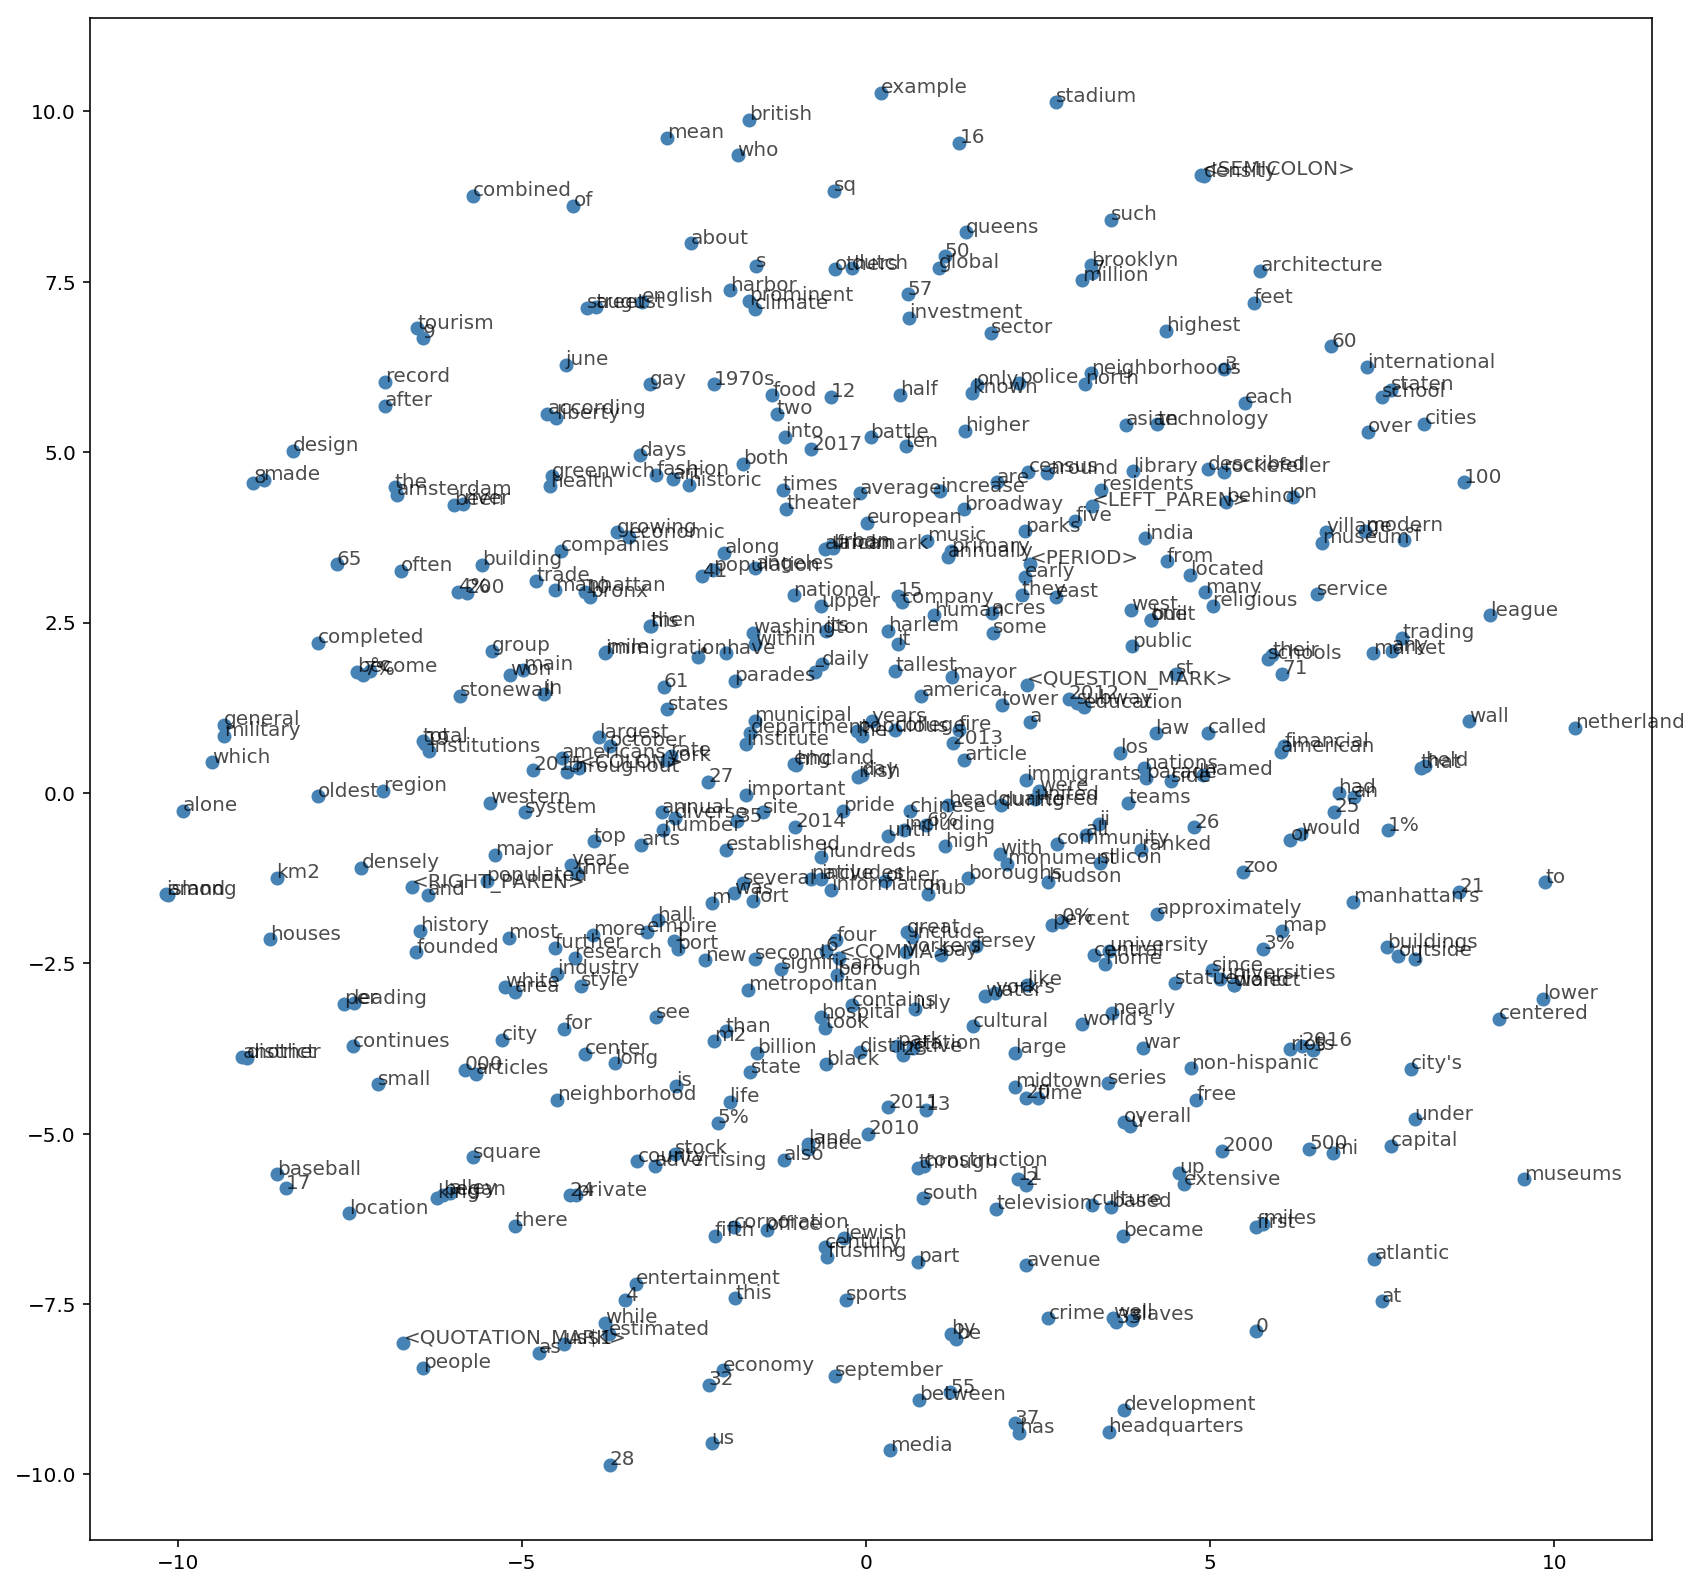

In [31]:
fig, ax = plt.subplots(figsize=(14, 14))
for idx in range(viz_words):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(int_to_vocab[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)

In [ ]:
embedding = tf.Variable(tf.random_uniform((n_vocab, n_embedding), -1, 1))
sess= tf.Session()
sess.run(tf.global_variables_initializer())
sess.run(embedding)

In [ ]:
params1 = tf.constant([1,2])
params2 = tf.constant([10,20])
ids = tf.constant([2,0,2,1,2,3])
result = tf.nn.embedding_lookup([params1, params2], ids)

sess= tf.Session()
sess.run(tf.global_variables_initializer())
sess.run(result)

In [ ]:
params1 = tf.constant([1,2])
params2 = tf.constant([10,20])
ids = tf.constant([2,0,2,1,2,3])
result = tf.nn.embedding_lookup([params1, params2], ids)

sess= tf.Session()
sess.run(tf.global_variables_initializer())
sess.run(result)

In [38]:
params1 = tf.constant([1,2])
params2 = tf.constant([10,20])
ids = tf.constant([2,0,2,1,2,3])
n_vocab = len(int_to_vocab)
n_embedding =  300
input1 = tf.placeholder(tf.int32, [None], name='input1')

em = tf.Variable(tf.random_uniform((n_vocab, n_embedding), -1, 1))
em1 = tf.nn.embedding_lookup(em, input1) # use tf.nn.embedding_lookup to get the hidden layer output
cost1=em1
sess= tf.Session()
sess.run(tf.global_variables_initializer())

epochs = 10
batch_size = 1000
window_size = 10


for e in range(1, epochs+1):
    batches = get_batches(train_words, batch_size, window_size)
    for x, y in batches:
       
        feed = {input1: x}
        em2 = sess.run([em1], feed_dict=feed)

sess.run(cost1)







InvalidArgumentError: You must feed a value for placeholder tensor 'input1_1' with dtype int32 and shape [?]
	 [[Node: input1_1 = Placeholder[dtype=DT_INT32, shape=[?], _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op 'input1_1', defined at:
  File "C:\Users\BRG_user\Anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\BRG_user\Anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\BRG_user\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\BRG_user\Anaconda3\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\BRG_user\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 478, in start
    self.io_loop.start()
  File "C:\Users\BRG_user\Anaconda3\lib\site-packages\zmq\eventloop\ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "C:\Users\BRG_user\Anaconda3\lib\site-packages\tornado\ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "C:\Users\BRG_user\Anaconda3\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\BRG_user\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "C:\Users\BRG_user\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\Users\BRG_user\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "C:\Users\BRG_user\Anaconda3\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\BRG_user\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "C:\Users\BRG_user\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\Users\BRG_user\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "C:\Users\BRG_user\Anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\BRG_user\Anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\BRG_user\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\BRG_user\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\Users\BRG_user\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-38-022a6906967c>", line 6, in <module>
    input1 = tf.placeholder(tf.int32, [None], name='input1')
  File "C:\Users\BRG_user\Anaconda3\lib\site-packages\tensorflow\python\ops\array_ops.py", line 1599, in placeholder
    return gen_array_ops._placeholder(dtype=dtype, shape=shape, name=name)
  File "C:\Users\BRG_user\Anaconda3\lib\site-packages\tensorflow\python\ops\gen_array_ops.py", line 3090, in _placeholder
    "Placeholder", dtype=dtype, shape=shape, name=name)
  File "C:\Users\BRG_user\Anaconda3\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "C:\Users\BRG_user\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 2956, in create_op
    op_def=op_def)
  File "C:\Users\BRG_user\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 1470, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): You must feed a value for placeholder tensor 'input1_1' with dtype int32 and shape [?]
	 [[Node: input1_1 = Placeholder[dtype=DT_INT32, shape=[?], _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]


ValueError: Cannot evaluate tensor using `eval()`: No default session is registered. Use `with sess.as_default()` or pass an explicit session to `eval(session=sess)`

In [35]:
n_vocab = len(int_to_vocab)
n_embedding =  300
n_vocab

471